# Results analysis for regular equivalence

In [ ]:
libs <- c(
  "dplyr",
  "tidyr",
  "forcats",
  "arrow",
  "igraph",
  "blockmodeling",
  "ggplot2",
  "svglite"
)
new.packages <- libs[!(libs %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages)
invisible(lapply(libs, library, character.only = TRUE))

Read graphs

In [3]:
types = c('replies', 'votes', 'follows')
gs = list()
n = 276
for (t in types) {
  gs[[t]] = read_graph(paste('graphs/',t,'-',n,'.graphml', sep=''), format = 'graphml')
}

Read results and group assignments from blockmodelling

In [13]:
res_bm = readRDS(paste('results/bm/', 'bm-all-', n, '-bin.rds', sep=''))
mem_bm = read.csv(paste('results/bm/', 'membership-', n, '.csv', sep=''))
k_bm = list(replies = 3, votes = 4, follows = 3)

## Blockmodelling

### Inspect relationship between groups

Build graph of relationships between different equivalence classes

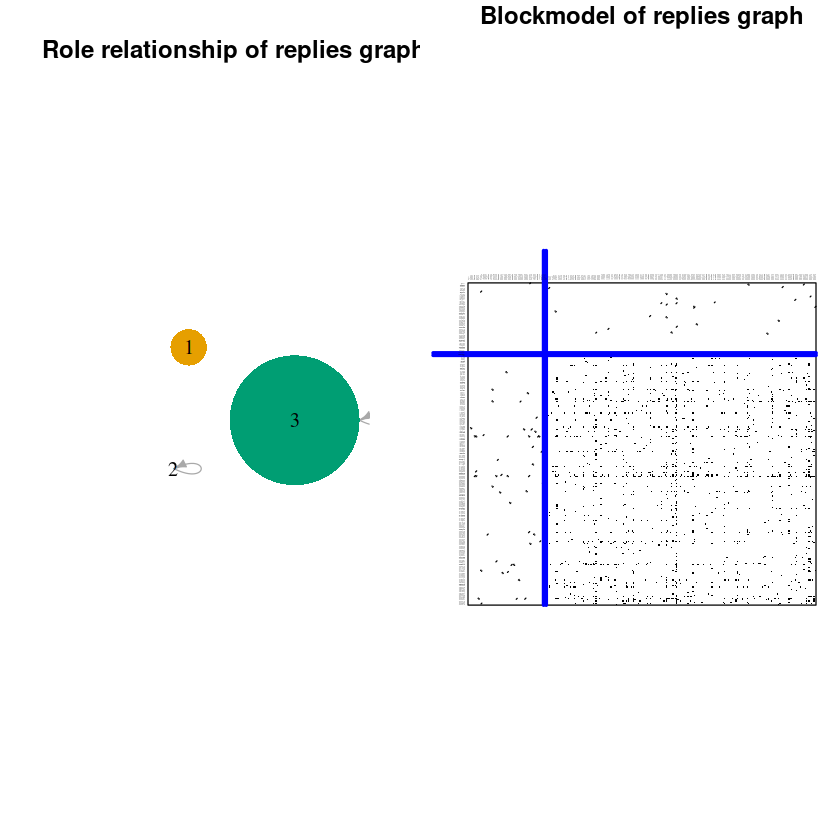

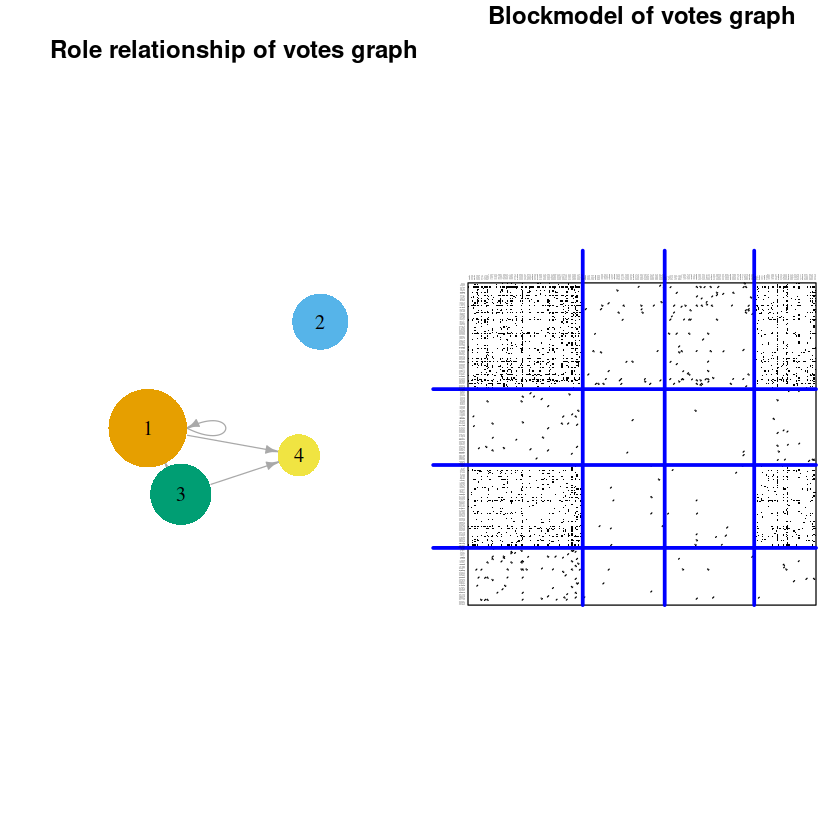

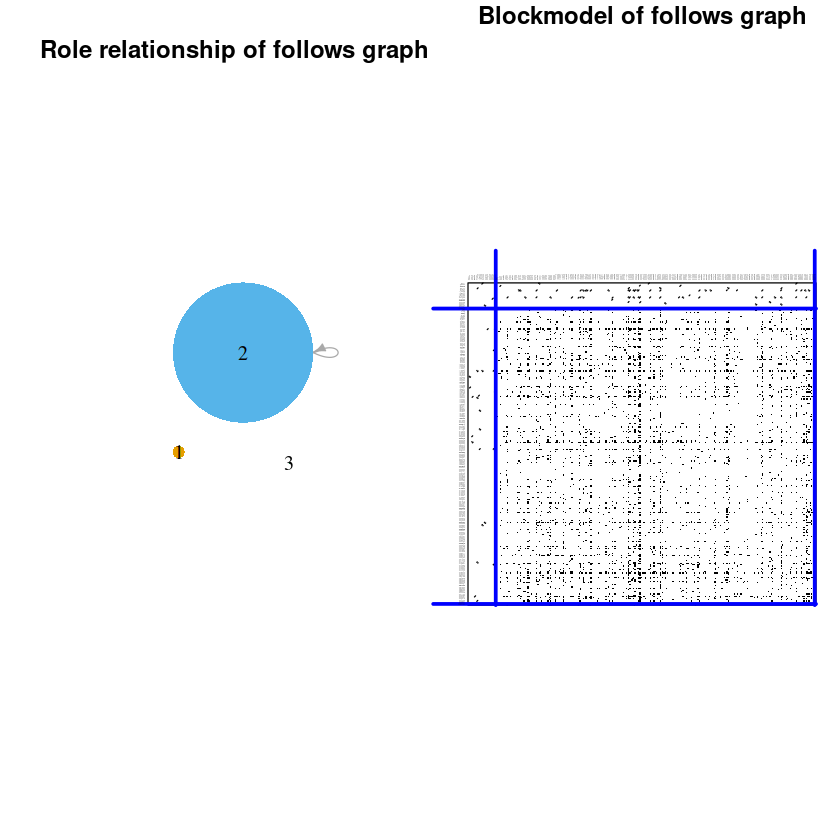

In [34]:
group_rel = list(3)
for (type in types) {
  A = IM(res_bm[[type]][[k_bm[[type]]]])

  A[A == 'com'] <- 1
  A[A == 'reg'] <- 1
  A[A == 'nul'] <- 0
  
  A = matrix(as.numeric(A), nrow = nrow(A), ncol = ncol(A))
  
  g <- graph_from_adjacency_matrix(A, mode = "directed", weighted = FALSE)
  
  group_col = paste('group_', type, sep='')
  
  group_sizes = count(mem_bm, !!sym((group_col)))
  
  # png(paste('results/bm/rel-', n, '-', type, '.png', sep=''))
  par(mfrow = c(1, 2))
  plot(g, layout = layout_with_fr(g, maxx=rep(400, vcount(g))),
       vertex.frame.width=0, vertex.color = V(g), vertex.size = group_sizes$n,vertex.label.color='black',
       edge.arrow.size = .5, loop.size = 1.5,
       main = paste('Role relationship of', type, 'graph')
  )
  plot(res_bm[[type]][[k_bm[[type]]]], main = paste('Blockmodel of', type, 'graph'),
      mar = c(1, 2, 3, 1), title.line = 2)
  # dev.off()
  group_rel[[type]] = g

  # Add group membership to graph
  gs[[type]]$group = clu(res_bm[[type]][[k_bm[[type]]]])
}

Visualise graph coloured by roles

### Inpsect combinations of group membership of nodes across replying, voting, following behaviours


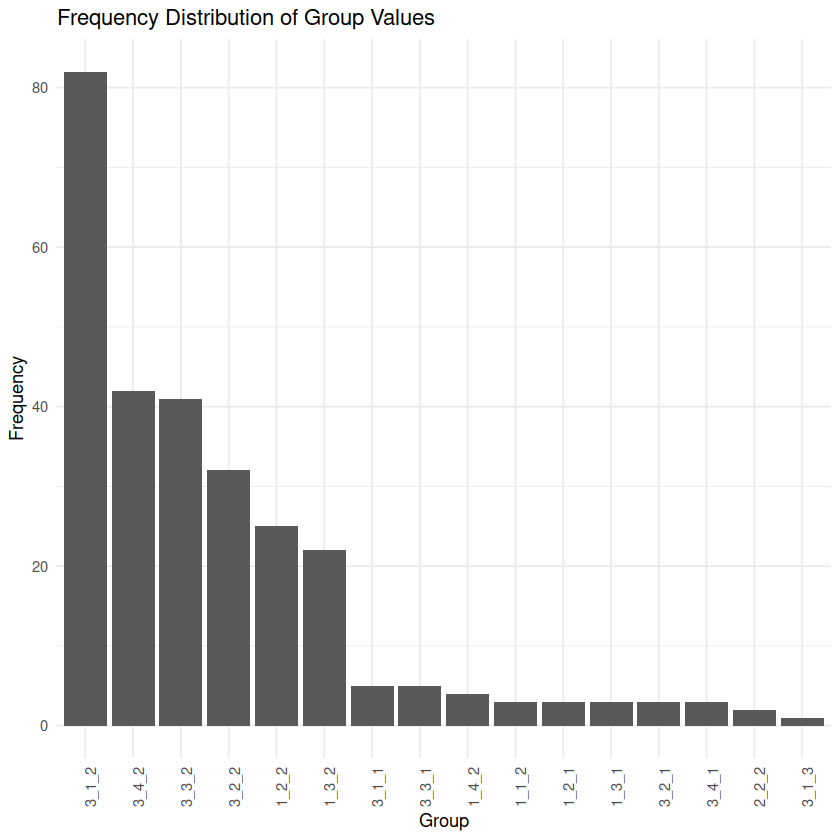

In [19]:
group_freq <- mem_bm %>%
  count(group)

# Plot the frequency distribution of the values in the 'group' column, sorted by frequency
ggplot(group_freq, aes(x = fct_reorder(group, n, .desc = TRUE), y = n)) +
  geom_bar(stat = 'identity') +
  labs(
    title = 'Frequency Distribution of Group Values',
    x = 'Group',
    y = 'Frequency'
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

### Inspect network properties by group

Calculate node level network properties

In [24]:
head(mem_bm)

,name,group,group_replies,group_votes,group_follows
,<int>,<chr>,<int>,<int>,<int>
1,38,3_2_2,3,2,2
2,4142,3_4_2,3,4,2
3,6334,3_1_2,3,1,2
4,6997,3_4_2,3,4,2
5,8071,1_3_1,1,3,1
6,8194,3_3_2,3,3,2


In [28]:
stats = list(3)

for (type in types) {
  group_col = paste('group_', type, sep='')
  stat = mem_bm %>% select(name, group_col)
  stat = stat %>%
    mutate(
      indegree = degree(gs[[type]], mode = 'in'),
      outdegree = degree(gs[[type]], mode = 'out'),
      betweenness = betweenness(gs[[type]]),
      eigen = eigen_centrality(gs[[type]])$vector
    )
  stats[[type]] = stat
}
stats[['replies']] %>% head()


,name,group_replies,indegree,outdegree,betweenness,eigen
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,38,3,1,1,0.0000,1.104684e-03
2,4142,3,1,1,0.0000,4.377643e-04
3,6334,3,6,8,822.8153,4.999292e-01
4,6997,3,1,1,0.0000,6.118253e-04
5,8071,1,0,1,0.0000,3.554514e-06
6,8194,3,1,1,0.0000,1.403068e-03


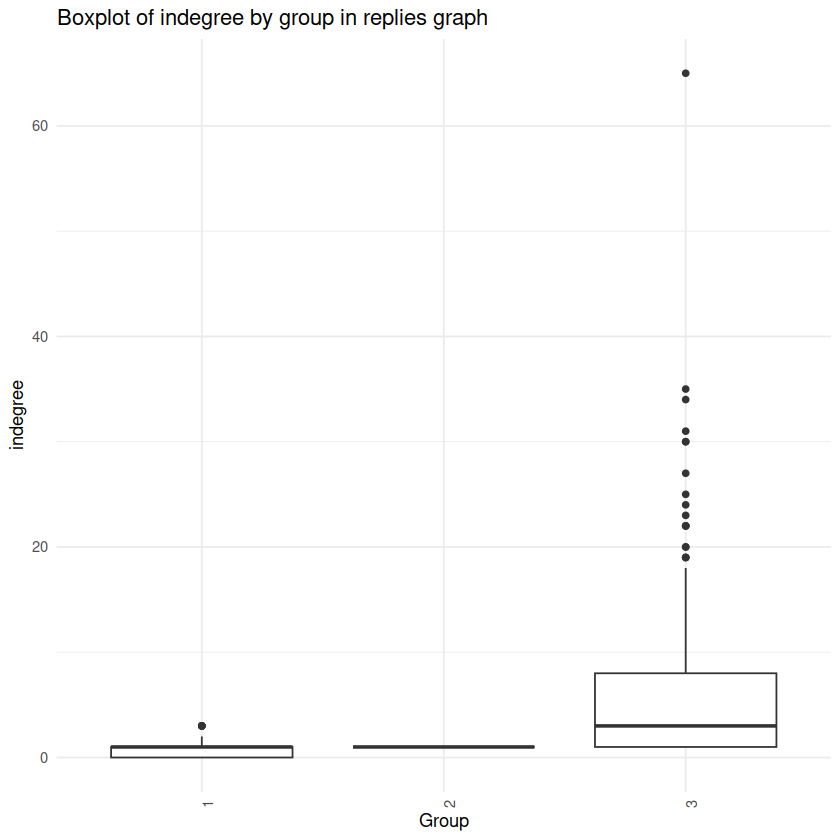

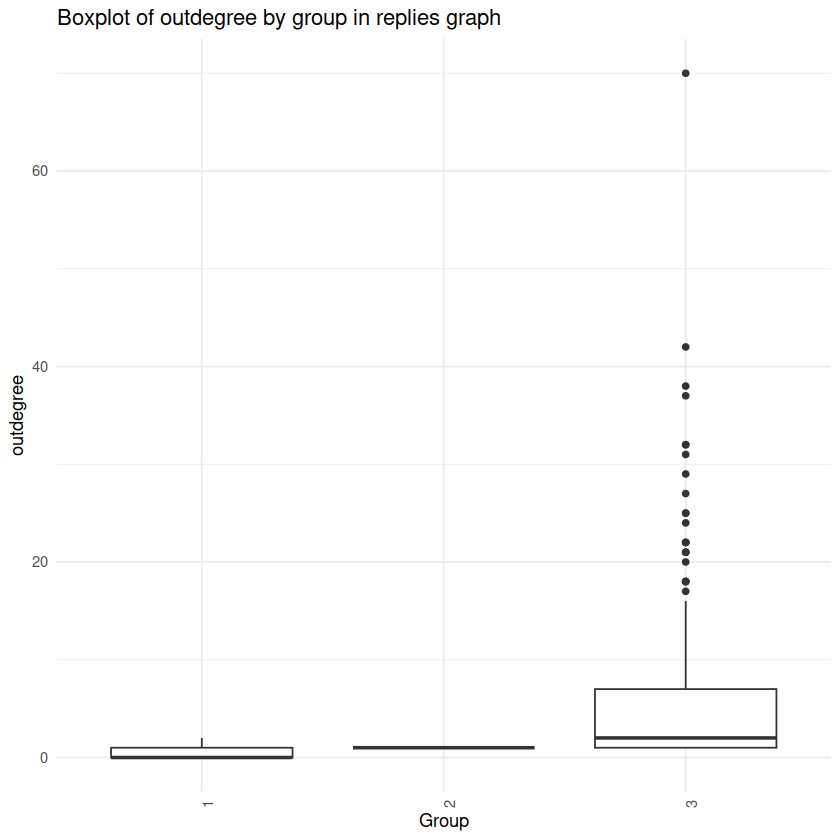

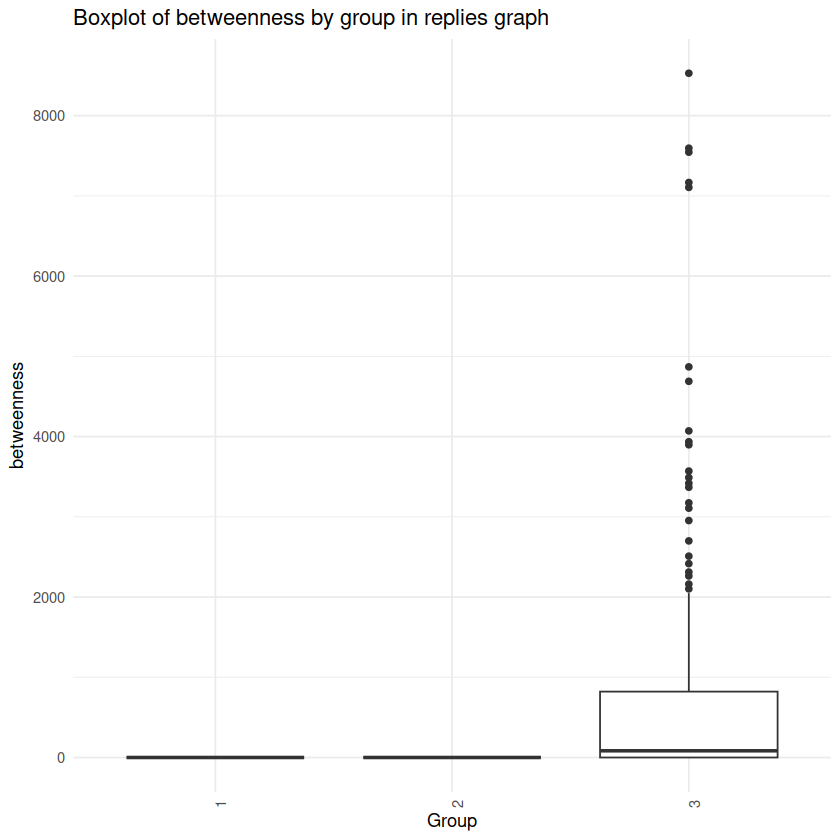

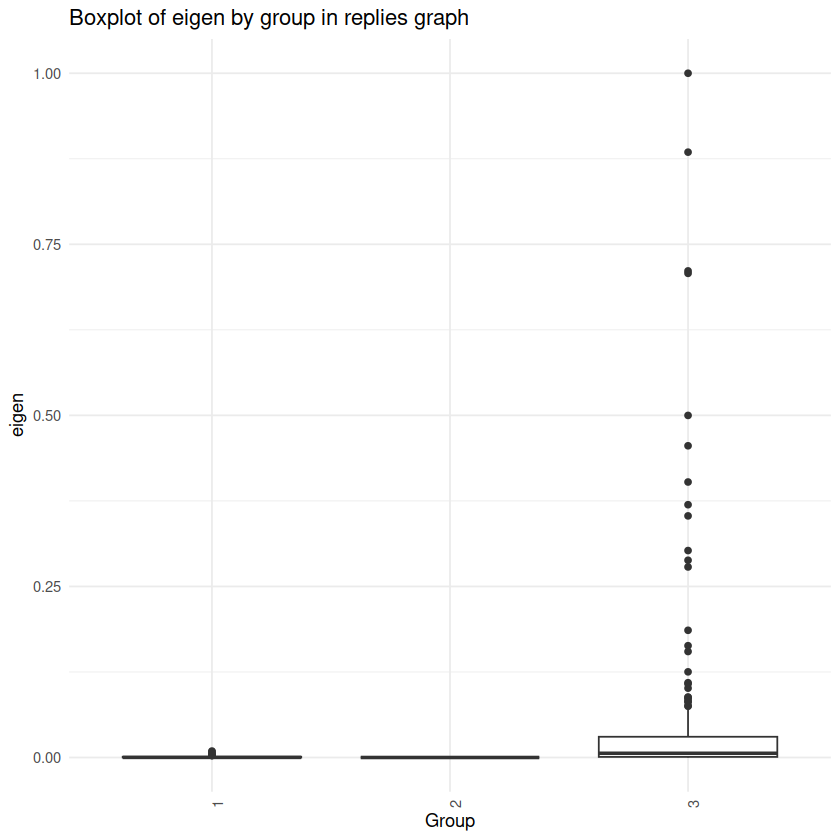

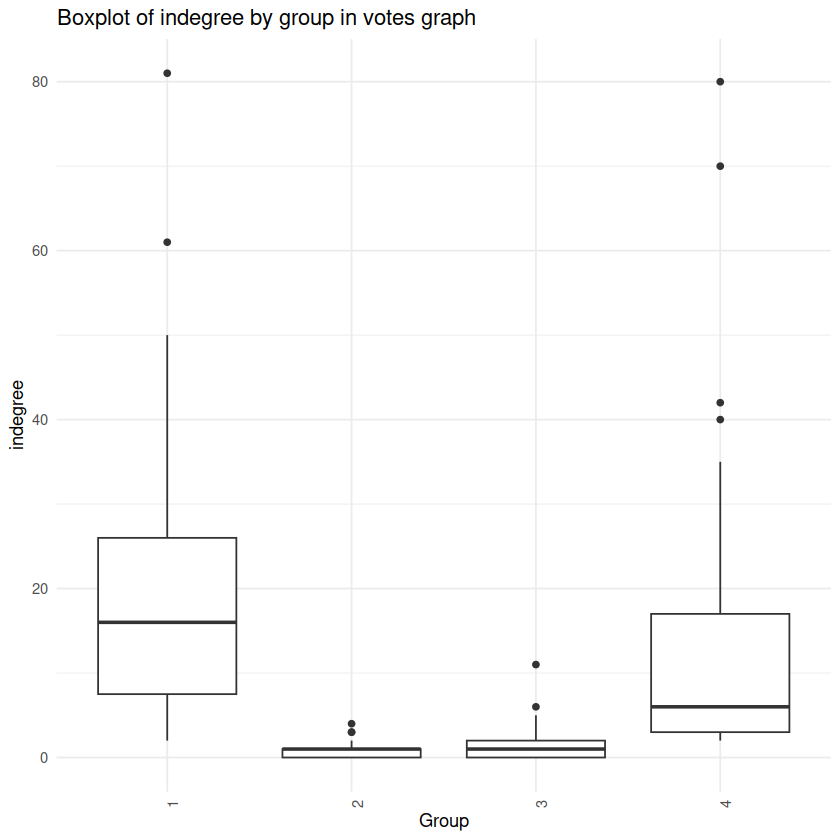

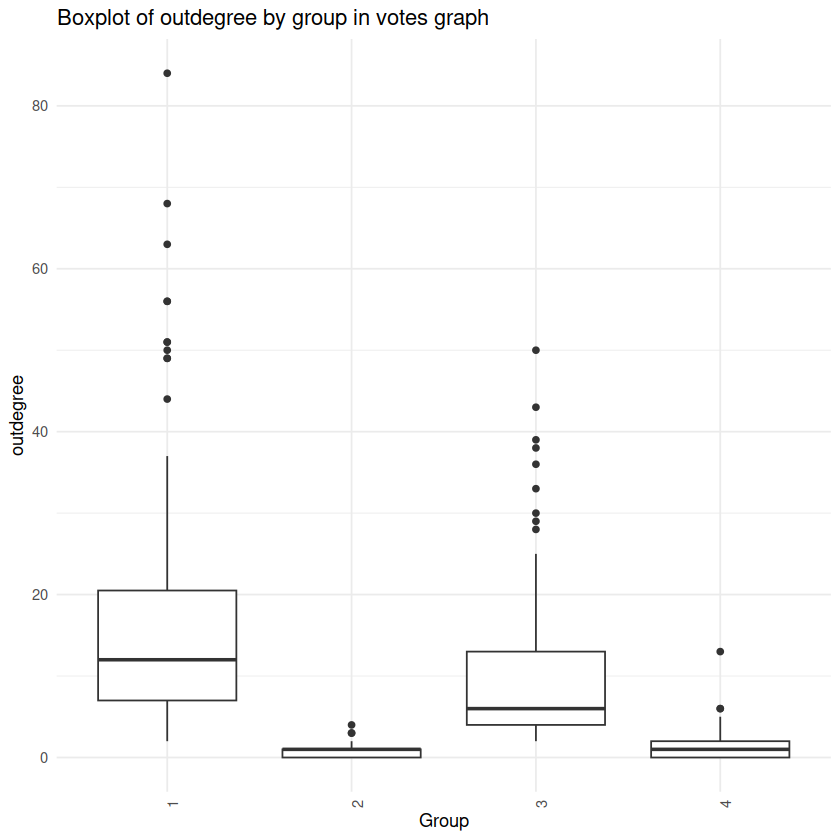

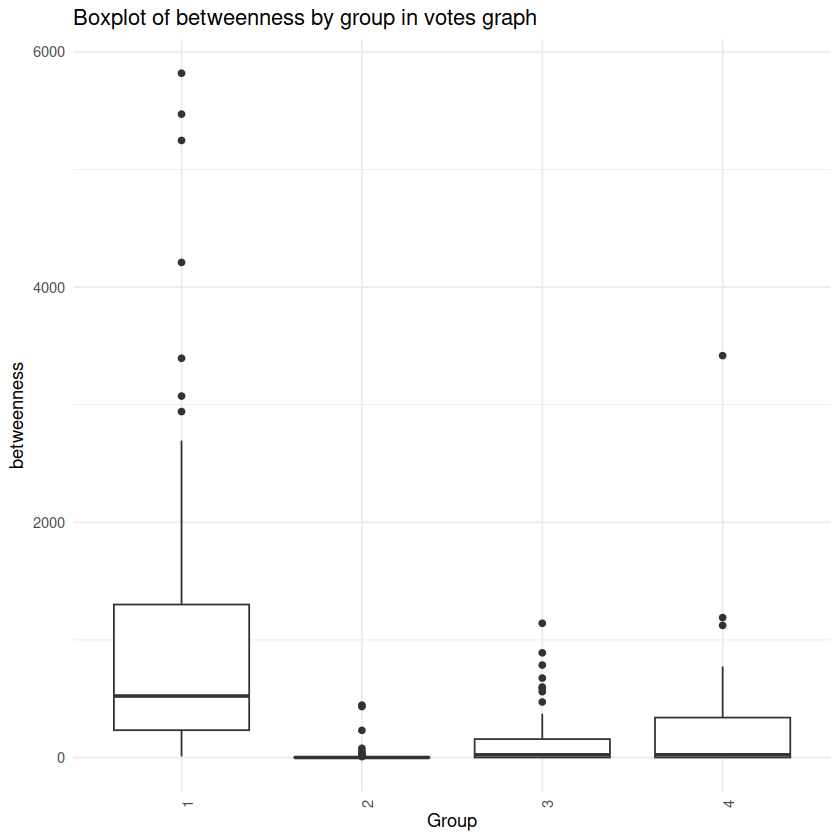

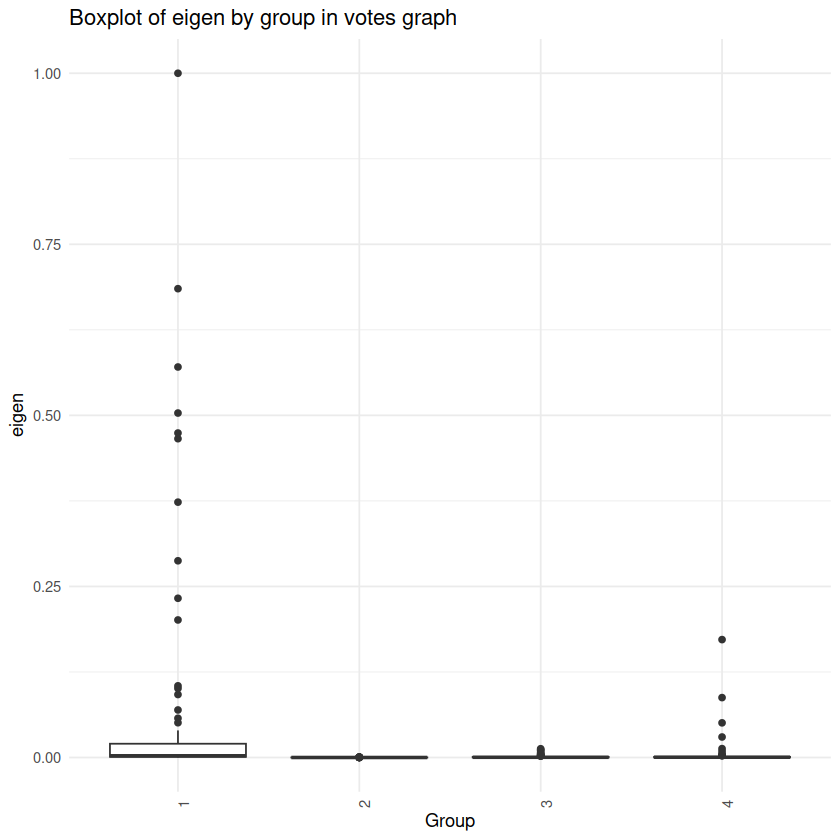

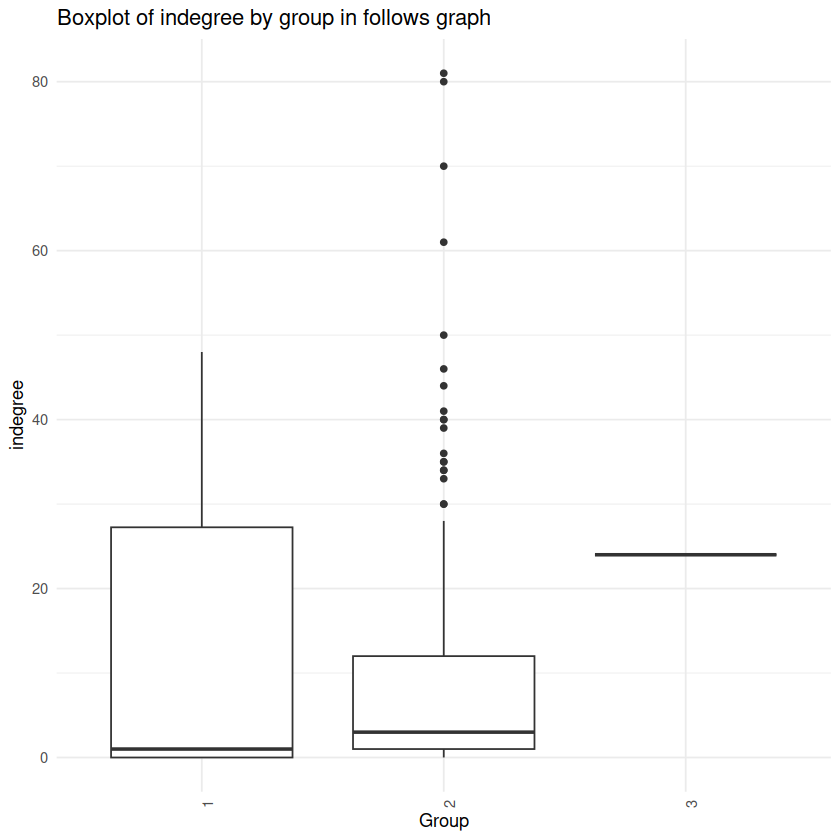

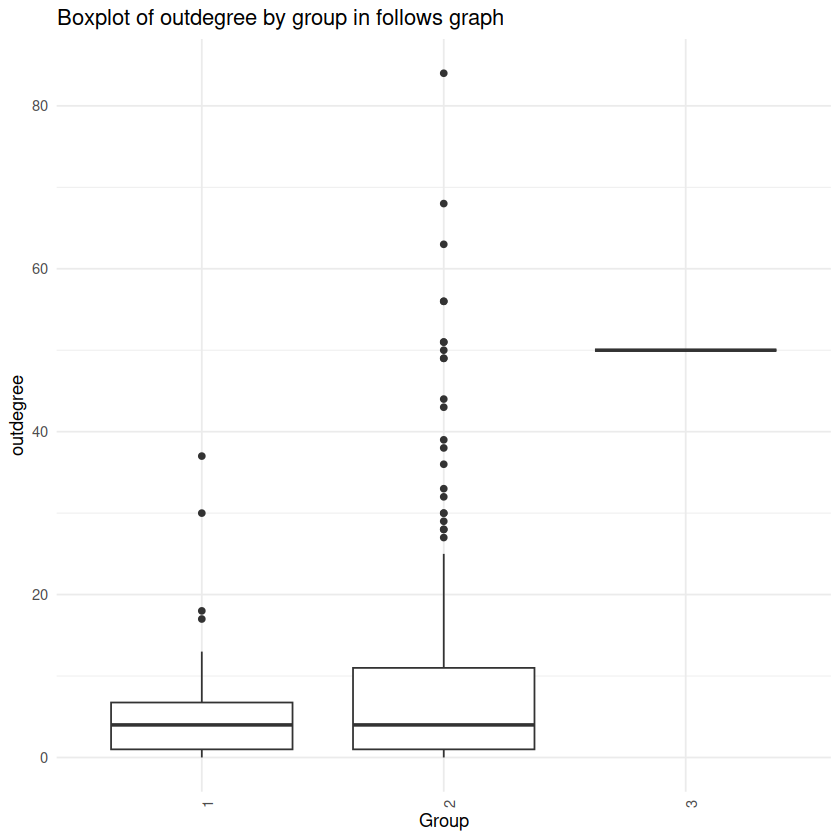

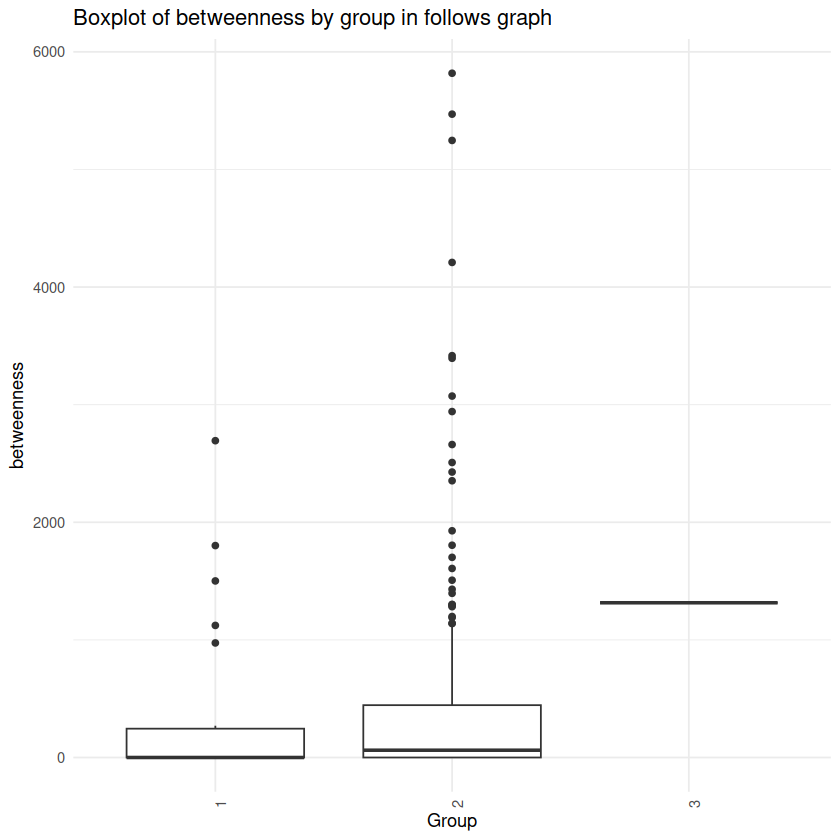

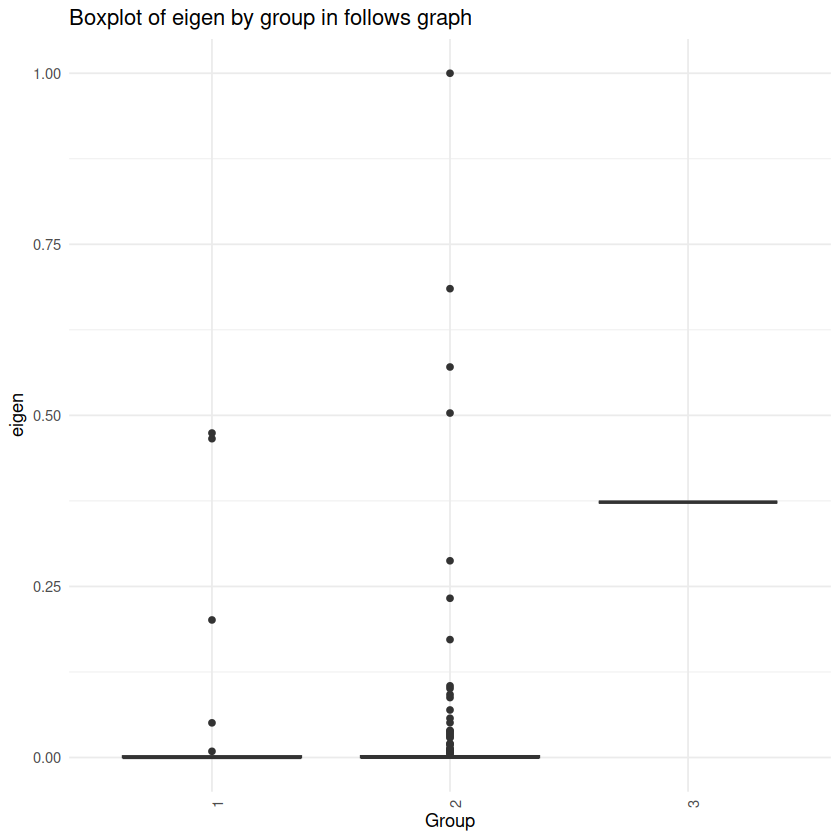

In [29]:
for (type in types) {
  x = paste('group_', type, sep='')
  for (col in c('indegree', 'outdegree', 'betweenness', 'eigen')) {
    p = ggplot(groups[[type]], aes(x = as.factor(.data[[x]]), y = .data[[col]])) +
      geom_boxplot() +
      labs(
        title = paste('Boxplot of', col, 'by group in', type, 'graph'),
        x = 'Group',
        y = col
      ) +
      theme_minimal() +
      theme(axis.text.x = element_text(angle = 90, hjust = 1))
    print(p)
    # ggsave(paste('results/bm/', type, '-', n, '-', col, '.svg', sep=''))
  }
}


## REGE


